# Spotify Charts – Feature Exploration

This notebook loads the processed Spotify tracks dataset and uses the `charts` module
(PCA + clustering helpers) to create statistical and fancy visualisations of the audio features.


### Load the data and the functions

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from datetime import datetime
import warnings
from data_visualisation import get_id_list
warnings.filterwarnings('ignore')

from charts import plot_pca_scatter, plot_clustered_pca
from data_visualisation import (
    load_data,
    get_track_appearances,
    plot_track_rankings,
    plot_streams_heatmap,
    prepare_longevity_data,
    plot_longevity_distribution,
    prepare_longevity_groups,
    plot_longevity_feature_comparison,
    plot_longevity_correlations,
    plot_longevity_scatter_plots,
    plot_longevity_curves,
    plot_longevity_ml_results,
)

sns.set_theme(style="whitegrid")

# DATA LOADING

# Path to the gold features file
DATA_PATH = "data/gold/"

# Load the data
songs = load_data(DATA_PATH)

# Quick overview
songs.head()

,track_id,artist_names,track_name,source,streams,week_date,duration_ms,explicit,artists,id_artists,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,3KkXRkHbMCARz0aVfEt68P,"Post Malone, Swae Lee",Sunflower - Spider-Man: Into the Spider-Verse,Universal Records,34579416,2019-01-17,158040.0,0.0,"['Post Malone', 'Swae Lee']","['246dkjvS1zLTtiykXe5h60', '1zNqQNIdeOUZHb8zbZ...",...,2.0,-5.574,1.0,0.0466,0.556,0.000000,0.0703,0.913,89.911,4.0
1,7xQAfvXzm3AkraOtGPWIZg,Post Malone,Wow.,Republic Records,29944242,2019-01-17,149547.0,1.0,['Post Malone'],['246dkjvS1zLTtiykXe5h60'],...,11.0,-7.359,0.0,0.2080,0.136,0.000002,0.1030,0.388,99.960,4.0
2,3e9HZxeyfWwjeyPAMmWSSQ,Ariana Grande,"thank u, next",Republic Records,27807232,2019-01-17,207320.0,1.0,['Ariana Grande'],['66CXWjxzNUsdJxJ2JdwvnR'],...,1.0,-5.634,1.0,0.0658,0.229,0.000000,0.1010,0.412,106.966,4.0
3,5p7ujcrUXASCNwRaWNHR1C,Halsey,Without Me,Capitol Records,27138512,2019-01-17,201661.0,1.0,['Halsey'],['26VFTg2z8YR0cCuwLzESi2'],...,6.0,-7.050,1.0,0.0705,0.297,0.000009,0.0936,0.533,136.041,4.0
4,5iwz1NiezX7WWjnCgY5TH4,"Pedro Capó, Farruko",Calma - Remix,Sony Music Latin,22816097,2019-01-17,238200.0,0.0,"['Pedro Capó', 'Farruko']","['4QVBYiagIaa6ZGSPMbybpy', '329e4yvIujISKGKz1B...",...,11.0,-4.218,0.0,0.0524,0.323,0.000000,0.1430,0.761,126.899,4.0


# Chart Longevity Analysis

In this notebook we analyze what makes songs last longer on the charts.

## A. Define Target Variable: Chart Longevity

We measure "lasting on the charts" using:
- **Weeks on Chart** (appearance_count): Number of weeks a track appears
- **Peak Rank**: Best position achieved
- **Stability Score**: Standard deviation of ranking (lower = more stable)

In [2]:
# Prepare longevity data
track_appearances = get_track_appearances(songs)
longevity_data = prepare_longevity_data(songs, track_appearances)

print(f"Total tracks analyzed: {len(longevity_data)}")
print(f"Average weeks on chart: {longevity_data['weeks_on_chart'].mean():.1f}")
print(f"Median weeks on chart: {longevity_data['weeks_on_chart'].median():.1f}")
print(f"Max weeks on chart: {longevity_data['weeks_on_chart'].max()}")


Total tracks analyzed: 2003
Average weeks on chart: 17.3
Median weeks on chart: 8.0
Max weeks on chart: 207


### Visualization 1: Distribution of Weeks on Chart

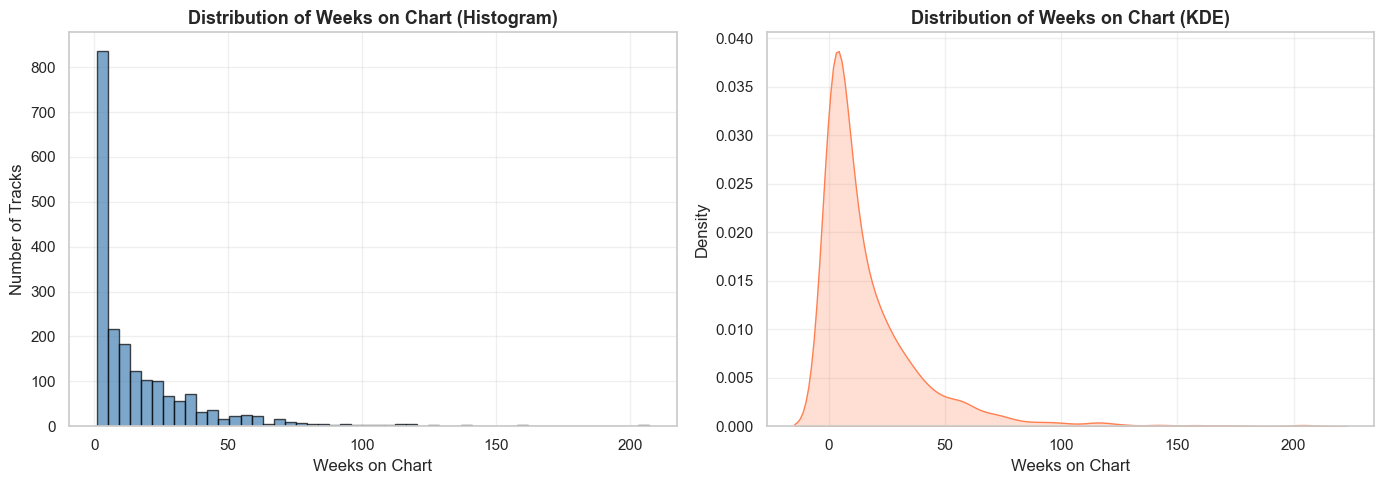


Distribution is right-skewed (Skewness: 3.15)


np.float64(3.153915346375899)

In [3]:
# Plot distribution of weeks on chart
plot_longevity_distribution(longevity_data)


### Visualisation 2: Most consistent songs on the charts

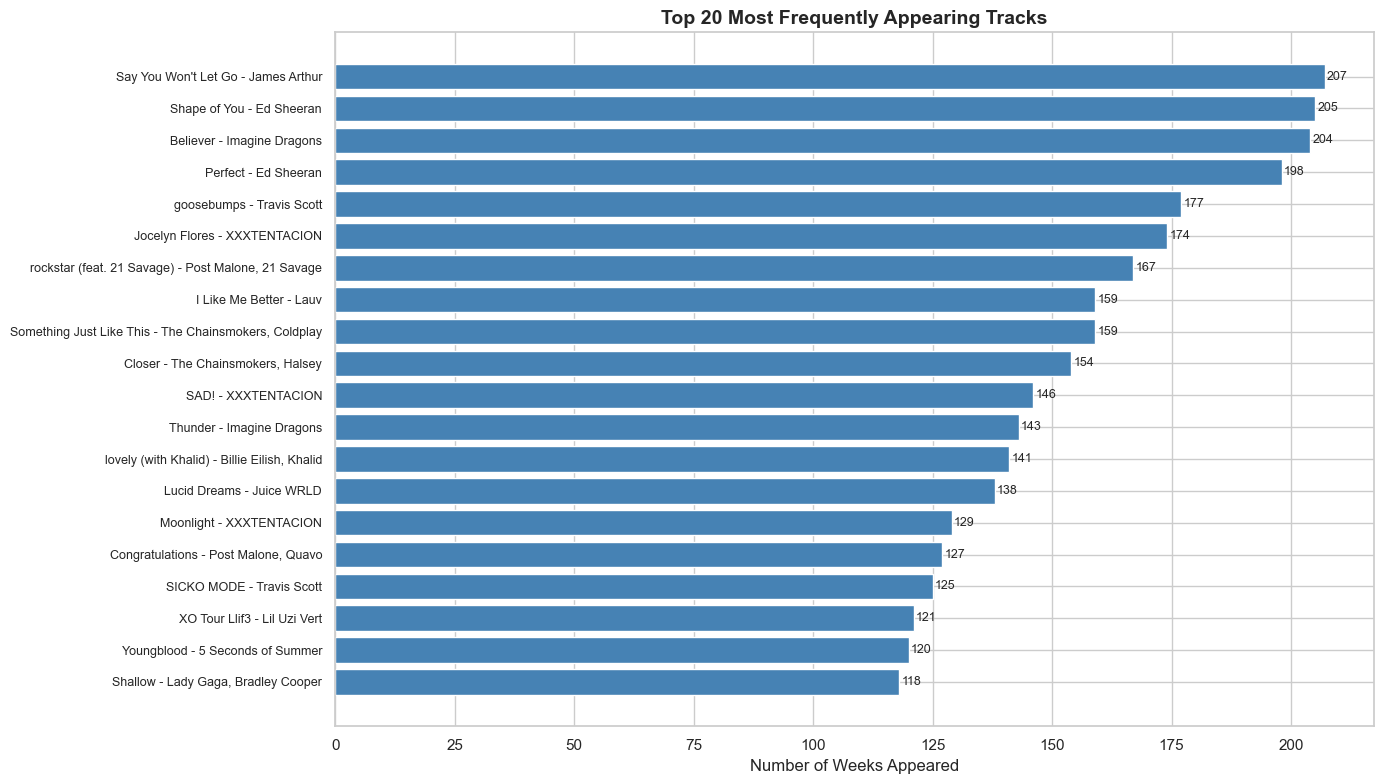


Total unique tracks: 2003

Top 5 tracks by appearance count:
                track_name     artist_names  appearance_count  total_streams  \
1507  Say You Won't Let Go     James Arthur               207     1362904001   
1947          Shape of You       Ed Sheeran               205     2651182795   
218               Believer  Imagine Dragons               204     1562472065   
241                Perfect       Ed Sheeran               198     1566968820   
1696            goosebumps     Travis Scott               177     1116644086   

       avg_streams  
1507  6.584077e+06  
1947  1.293260e+07  
218   7.659177e+06  
241   7.913984e+06  
1696  6.308724e+06  


In [4]:
# Ranking of most appearing track IDs
top_tracks = plot_track_rankings(track_appearances, top_n=20)

print(f"\nTotal unique tracks: {songs['track_id'].nunique()}")
print(f"\nTop 5 tracks by appearance count:")
print(top_tracks[['track_name', 'artist_names', 'appearance_count', 'total_streams','avg_streams']].head())

### Visualisation 3: Streams patterns for most consistent songs on the charts

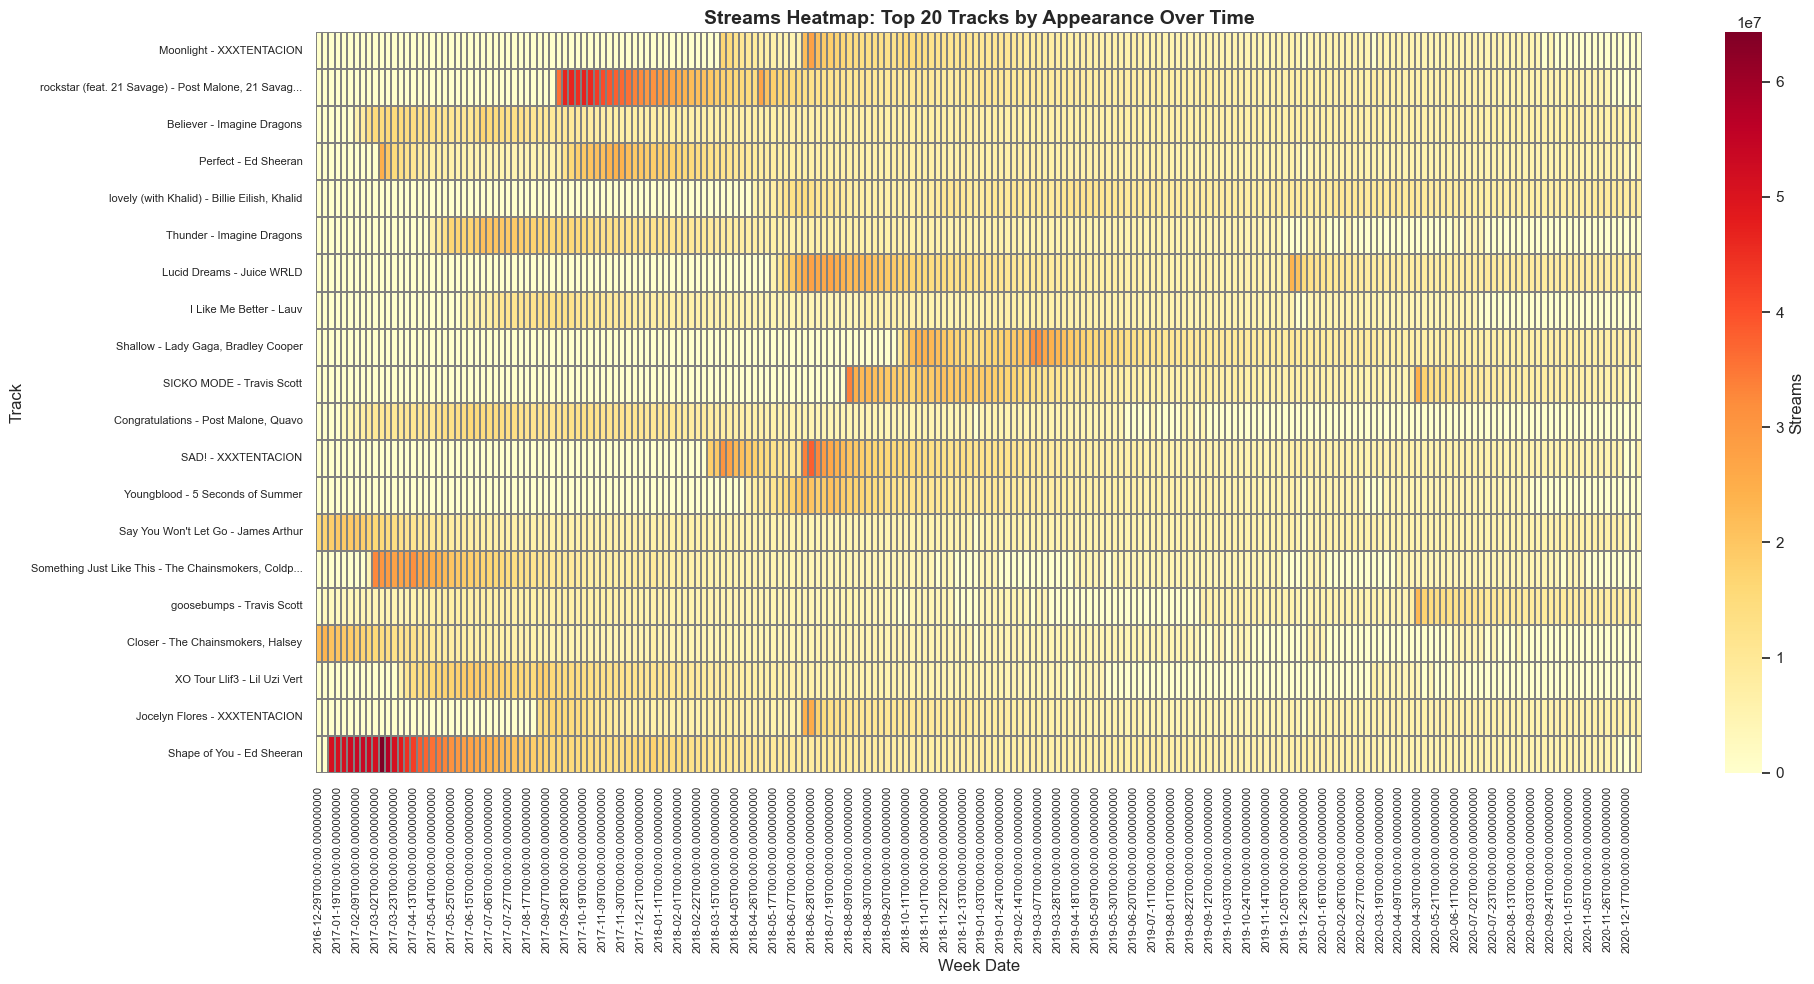

In [5]:
# Heatmap: Streams by track and week (for top 20 tracks by appearance)
plot_streams_heatmap(songs, track_appearances, top_n=20)


## B. Compare Audio Features: Short-lived vs Long-lasting Hits


We define two groups:
- **Short-lived hits**: songs staying ≤ 8 weeks
- **Long-lasting hits**: songs staying ≥ 15 weeks

In [6]:
# Prepare groups for comparison
short_lived, long_lasting, comparison_data = prepare_longevity_groups(longevity_data)

print(f"Short-lived hits (≤8 weeks): {len(short_lived)} tracks")
print(f"Long-lasting hits (≥8 weeks): {len(long_lasting)} tracks")


Short-lived hits (≤8 weeks): 1010 tracks
Long-lasting hits (≥8 weeks): 729 tracks


### Visualization 4: Audio Features Comparison (Boxplots)

@TODO Add legend

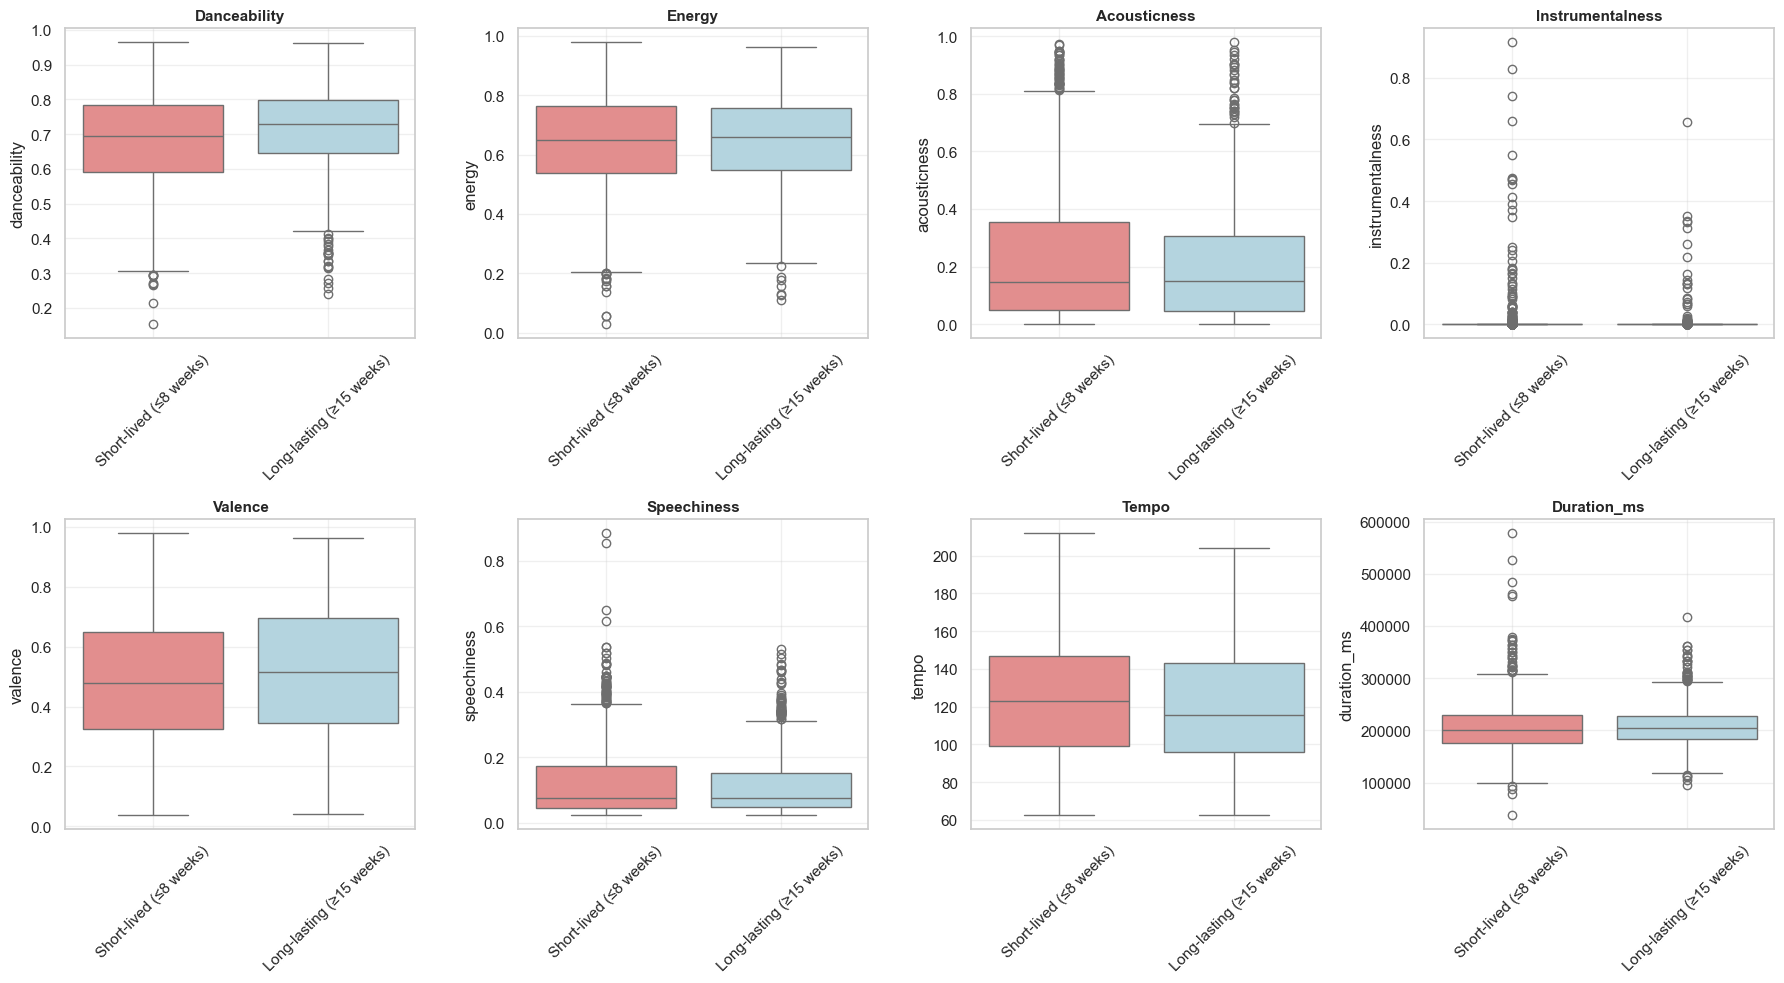


Summary Statistics:
danceability        : Short=  0.682, Long=  0.711, Diff=  0.028
energy              : Short=  0.638, Long=  0.644, Diff=  0.006
acousticness        : Short=  0.241, Long=  0.215, Diff= -0.026
instrumentalness    : Short=  0.011, Long=  0.005, Diff= -0.006
valence             : Short=  0.491, Long=  0.516, Diff=  0.025
speechiness         : Short=  0.129, Long=  0.119, Diff= -0.010
tempo               : Short=124.595, Long=121.303, Diff= -3.292
duration_ms         : Short=206541.777, Long=208364.075, Diff=1822.298


In [7]:
# Plot feature comparison boxplots
plot_longevity_feature_comparison(comparison_data, short_lived, long_lasting)


### C. Feature-Longevity Correlations

### Visualization 5: Correlation Heatmap (Features vs Weeks on Chart)

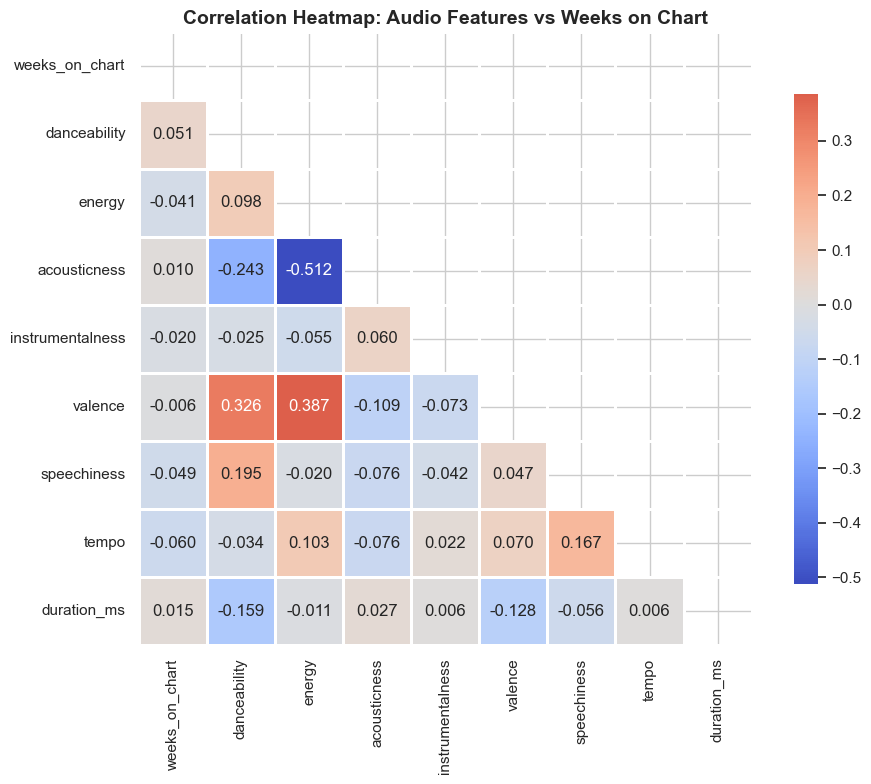


Correlations with Weeks on Chart:
danceability        0.050980
duration_ms         0.015335
acousticness        0.010278
valence            -0.005821
instrumentalness   -0.020033
energy             -0.041049
speechiness        -0.049220
tempo              -0.060228
Name: weeks_on_chart, dtype: float64


In [8]:
# Plot correlation heatmap
longevity_correlations = plot_longevity_correlations(longevity_data)


### D. Relationship Plots

### Visualization 6: Scatter Plots with Regression Lines (Top Correlated Features)

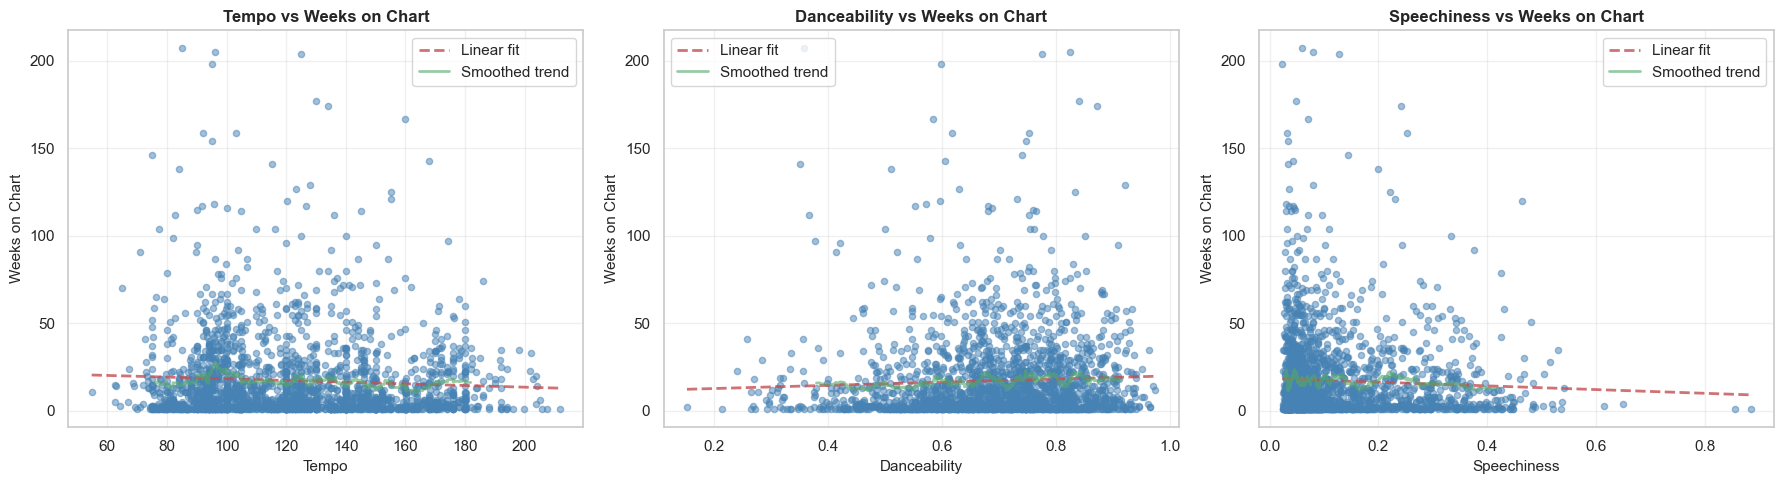


Top 3 features analyzed: tempo, danceability, speechiness


In [9]:
# Plot scatter plots with regression lines
plot_longevity_scatter_plots(longevity_data, longevity_correlations, n_features=3)


### E. Longevity Curves (Survival-Style Analysis)

### Visualization 7: Average Chart Rank Over Weeks by Feature Quantiles

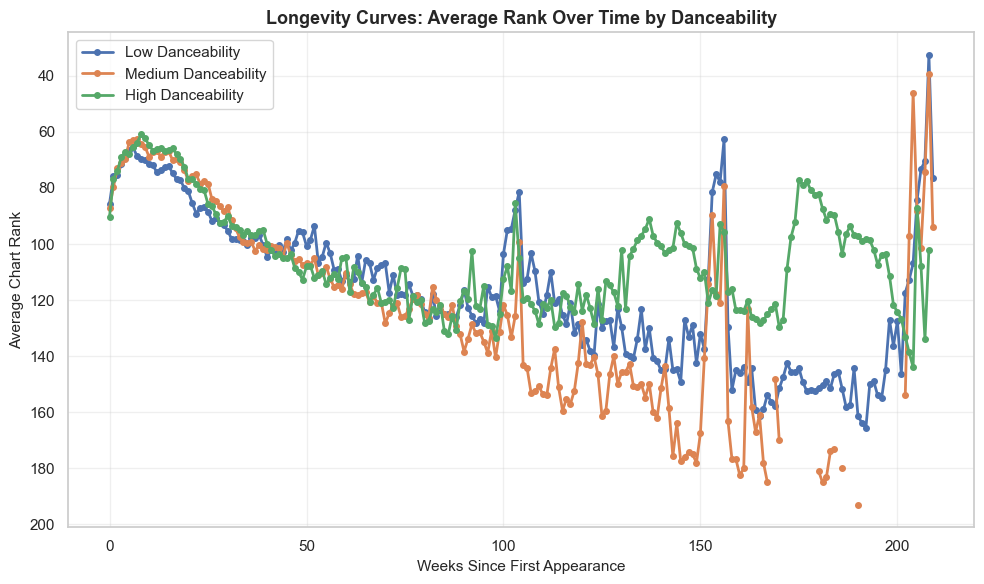

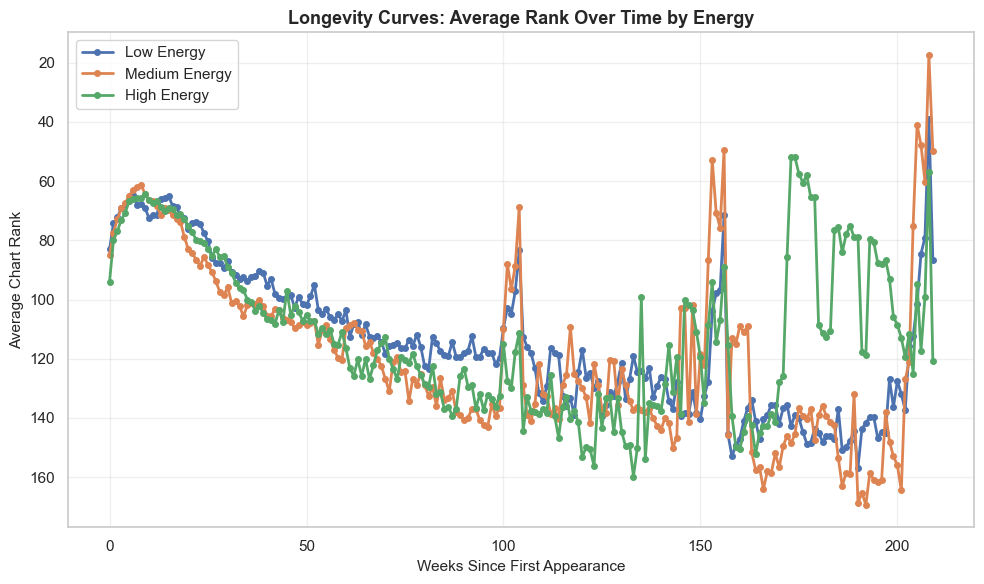


Longevity curves show how tracks decline over time.
Lower rank = better position (rank 1 is #1 on chart).


In [10]:
# Get track features for longevity curves
track_features = songs.groupby('track_id').first()[['danceability', 'energy']].reset_index()

# Plot longevity curves by danceability
plot_longevity_curves(songs, track_features, feature='danceability')

# Plot longevity curves by energy
plot_longevity_curves(songs, track_features, feature='energy')

print("\nLongevity curves show how tracks decline over time.")
print("Lower rank = better position (rank 1 is #1 on chart).")


# Extension
Since tehre is no clear linear combination (not found using either linear reg, plotting or correlation matrices), we have made a small extension of our work to find interesting patterns. using a model with high explainability and no linear correlation expected such as a tree based model enabled us to find interesting patterns in non time dependant features for creating an interesting song. 

This section uses machine learning models to predict song longevity (weeks on chart) using only **non-temporal features** - the inherent characteristics of songs that don't depend on time or historical performance.

**Features used:**
- Audio characteristics: danceability, energy, acousticness, instrumentalness, valence, speechiness, tempo
- Metadata: duration_ms, explicit
- Artist count: number of artists per track

**Target:** Classification into longevity categories:
- **Short-lived** (≤8 weeks)
- **Medium** (9-14 weeks)
- **Long-lasting** (≥15 weeks)

In [11]:
from data_visualisation import prepare_longevity_features, train_longevity_classification_models
from sklearn.model_selection import train_test_split

# Prepare features for longevity prediction
X, y, feature_names, longevity_df = prepare_longevity_features(songs, track_appearances)

# Split into train/test (random split since we're not using temporal features)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")


Longevity Prediction Data Preparation:
Total tracks: 2003
Features: ['danceability', 'energy', 'acousticness', 'instrumentalness', 'valence', 'speechiness', 'tempo', 'duration_ms', 'explicit', 'num_artists']

Longevity category distribution:
longevity_category
Long      993
Short    1010
Name: count, dtype: int64

Feature matrix shape: (2003, 10)

Train set: 1602 samples
Test set: 401 samples


LONGEVITY CLASSIFICATION MODELS (Binary)
Classes: 0=Short (≤8 weeks), 1=Long (≥9 weeks)
Training samples: 1602, Test samples: 401

1. Logistic Regression (Binary):
   Accuracy: 0.5262
   Precision (macro): 0.5261
   Recall (macro): 0.5260
   F1-Score (macro): 0.5258
   ROC-AUC (macro): 0.0000

2. Random Forest Classifier (Binary):
   Accuracy: 0.5686
   Precision (macro): 0.5687
   Recall (macro): 0.5686
   F1-Score (macro): 0.5686
   ROC-AUC (macro): 0.0000

3. XGBoost: Not available (install with: pip install xgboost)

Detailed Classification Report (RF - Best Model):
              precision    recall  f1-score   support

       Short       0.57      0.56      0.57       202
        Long       0.56      0.58      0.57       199

    accuracy                           0.57       401
   macro avg       0.57      0.57      0.57       401
weighted avg       0.57      0.57      0.57       401



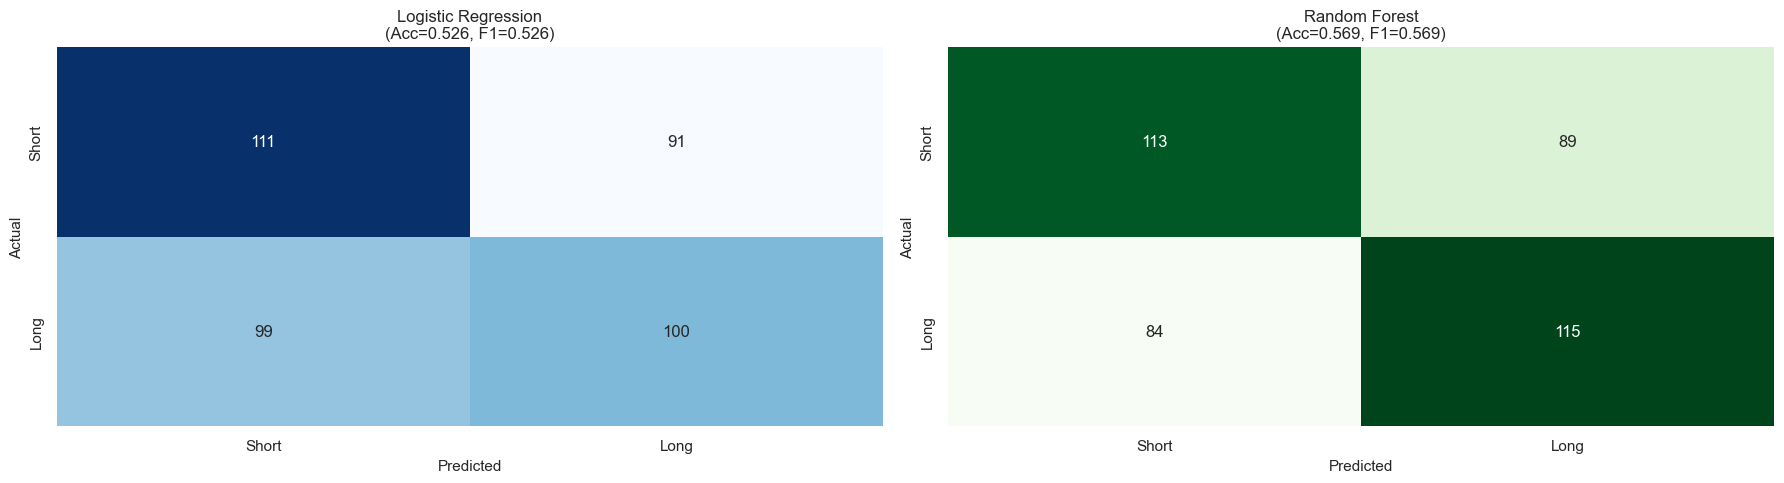

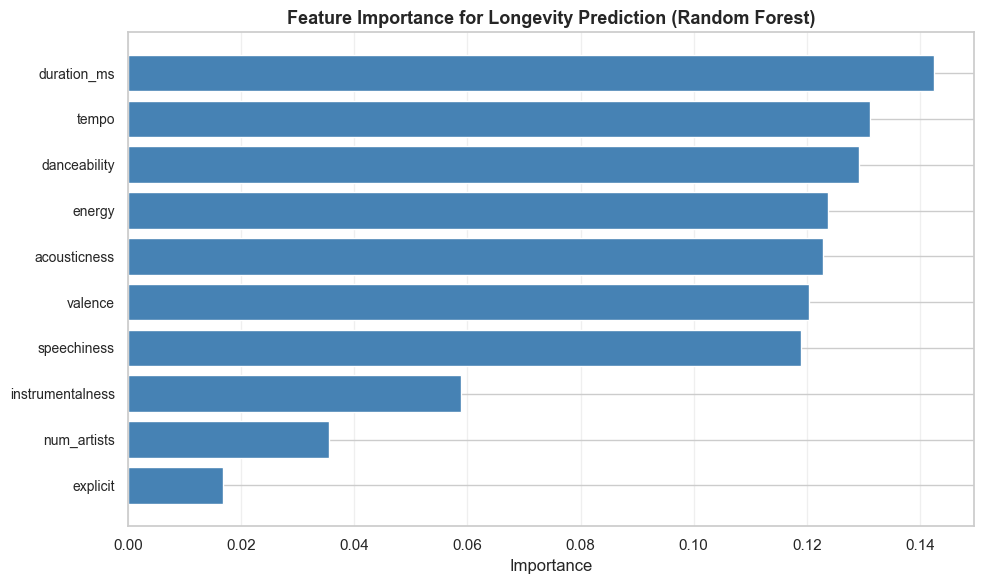


Top Features for Longevity Prediction:
         feature  importance
     duration_ms    0.142451
           tempo    0.131268
    danceability    0.129200
          energy    0.123703
    acousticness    0.122824
         valence    0.120458
     speechiness    0.118971
instrumentalness    0.058774
     num_artists    0.035521
        explicit    0.016830


In [12]:
# Train longevity classification models
longevity_results = train_longevity_classification_models(
    X_train, y_train, X_test, y_test, feature_names
)

# Plot results and features importance
feature_importance = plot_longevity_ml_results(longevity_results, y_test, feature_names)

# Key Insights